In [1]:
text_labels = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

In [2]:
import tensorflow as tf
import numpy as np
import random
import scipy.io
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small, MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
## UNCOMMENT ONLY IF UNZIPPING DATASET ###

import zipfile

with zipfile.ZipFile("jpg.zip", "r") as zip_ref:
    zip_ref.extractall("images")


folder_path = "images/jpg"

# Count all files (excluding subdirectories)
file_count = sum(1 for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file)))

print(f"Number of files: {file_count}")


Number of files: 8189


### Augmentation

In [37]:
class OxfordFlowersDataset:
    def __init__(self, image_folder, label_file):
        self.image_folder = image_folder
        self.label_file = label_file
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        self.labels = self._load_labels()

    def _load_labels(self):
        label_data = scipy.io.loadmat(self.label_file)
        image_labels = label_data['labels'].flatten() - 1
        return to_categorical(image_labels, num_classes=102)

def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def random_zoom(image, min_zoom=0.8, max_zoom=1.2):
    zoom_factor = tf.random.uniform(shape=[], minval=min_zoom, maxval=max_zoom)
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    crop_h, crop_w = tf.cast(tf.cast(h, tf.float32) * zoom_factor, tf.int32), tf.cast(tf.cast(w, tf.float32) * zoom_factor, tf.int32)
    image = tf.image.central_crop(image, zoom_factor)
    image = tf.image.resize(image, [h, w])
    return image

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
    image = image + noise
    image = tf.clip_by_value(image, -1.0, 1.0)
    return image

def to_tf_dataset(image_paths, labels, batch_size=128, shuffle=True, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if training:
        load_fn = lambda x, y: (augment_image(load_image(x, y)[0]), y)
    else:
        load_fn = load_image
    dataset = dataset.map(load_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load Dataset and split (same as before)
dataset = OxfordFlowersDataset("images/jpg", "imagelabels.mat")
image_paths = [os.path.join("images/jpg", f) for f in dataset.image_files]
labels = dataset.labels
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)
label_indices = np.argmax(labels, axis=1)
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=label_indices, random_state=42)
train_dataset = to_tf_dataset(train_paths, train_labels, training=True)
val_dataset = to_tf_dataset(val_paths, val_labels, training=False)

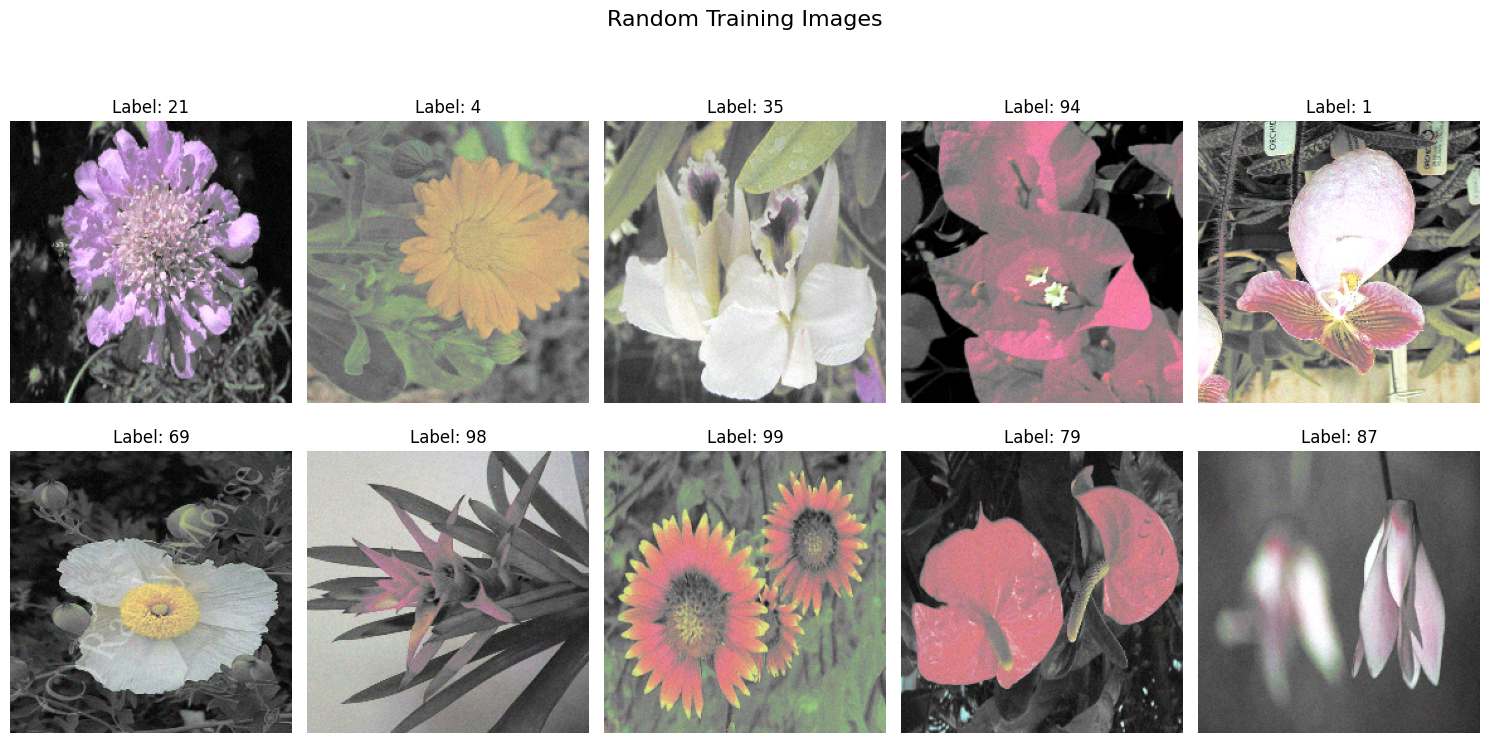

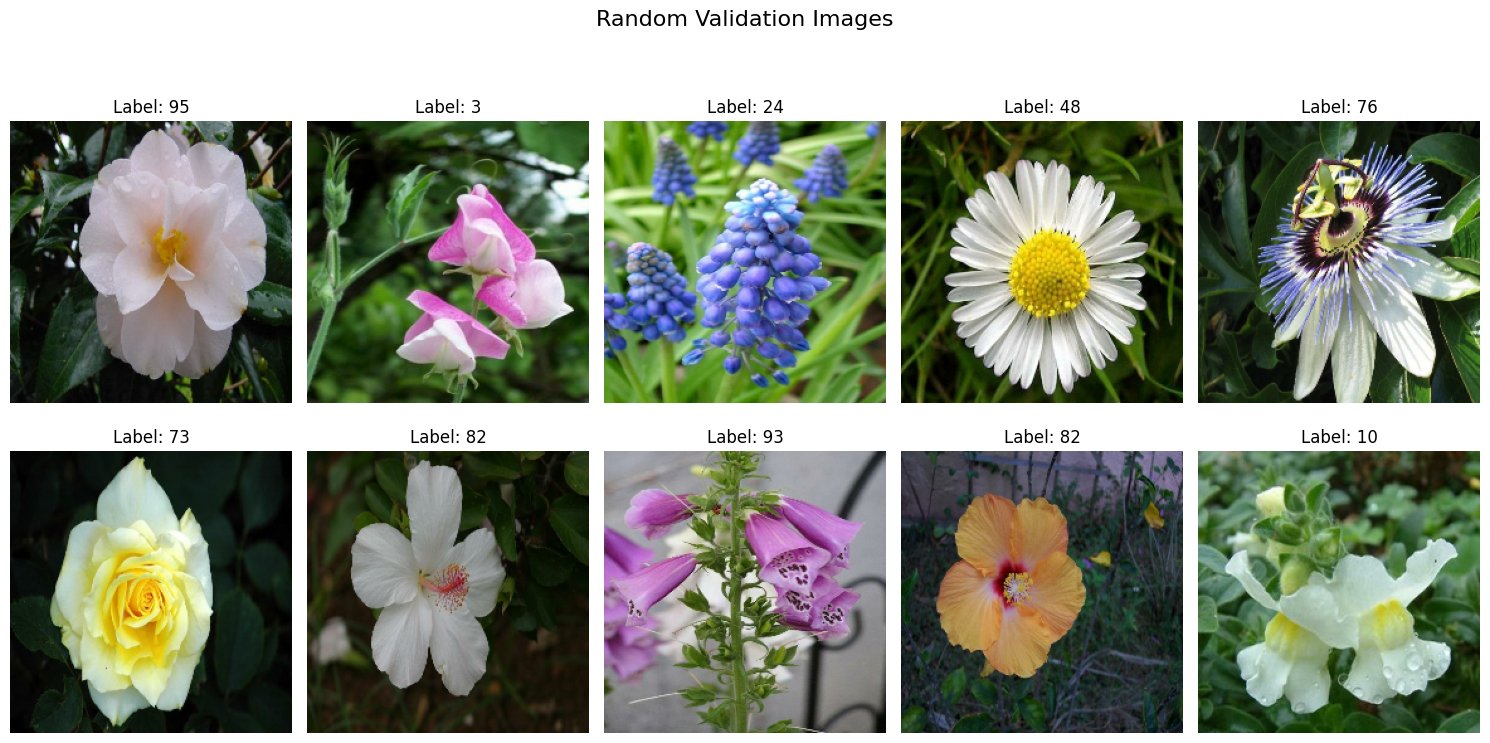

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(dataset, num_images=10, title=""):
    """Displays a grid of images from a tf.data.Dataset.

    Args:
        dataset: A tf.data.Dataset containing (image, label) pairs.
        num_images: The number of images to display.
        title: The title of the plot.
    """
    # Take a subset of the dataset.  We use 'take' because datasets can be infinite.
    subset = dataset.take(num_images)

    plt.figure(figsize=(15, 8))  # Adjust figure size as needed
    plt.suptitle(title, fontsize=16)

    for i, (image, label) in enumerate(subset):
        plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots

        # --- Important: Reverse Preprocessing for Display ---
        # Since the images are preprocessed to [-1, 1], we need to
        # reverse this to [0, 1] for proper display with imshow.
        display_image = (image.numpy() + 1) / 2.0

        # Ensure the image is within the valid range [0, 1]
        display_image = np.clip(display_image, 0, 1)

        plt.imshow(display_image)
        plt.title(f"Label: {np.argmax(label.numpy())}")  # Show the class label
        plt.axis('off')  # Hide axes

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent title overlap
    plt.show()

# --- Display Training Images ---
display_images(train_dataset.unbatch(), num_images=10, title="Random Training Images")

# --- Display Validation Images ---
display_images(val_dataset.unbatch(), num_images=10, title="Random Validation Images")

In [41]:
# Load MobileNetV3 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(102, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))  # 102 flower classes
])

# Compile Model (Feature Extraction)
model.compile(
      optimizer=optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

# Train for initial feature extraction
initial_epochs = 20
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=initial_epochs
)


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 255ms/step - accuracy: 0.1035 - loss: 4.5359 - val_accuracy: 0.4072 - val_loss: 2.8585
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.4947 - loss: 2.2759 - val_accuracy: 0.5696 - val_loss: 2.1950
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.6474 - loss: 1.6510 - val_accuracy: 0.6197 - val_loss: 1.9227
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7210 - loss: 1.3705 - val_accuracy: 0.6270 - val_loss: 1.8081
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7424 - loss: 1.2462 - val_accuracy: 0.6612 - val_loss: 1.6768
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.7810 - loss: 1.1204 - val_accuracy: 0.6758 - val_loss: 1.6018
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8061 - loss: 1.0337 - val_accuracy: 0.6758 - val_loss: 1.5716
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8172 - loss: 0.9864 - val_accu

In [42]:


# Fine-Tune: Unfreeze Last Few Layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # Keep first 30 layers frozen

# Lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

# Fine-Tune Model
fine_tune_epochs = 100
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=fine_tune_epochs,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 320ms/step - accuracy: 0.7371 - loss: 1.3484 - val_accuracy: 0.5922 - val_loss: 1.7164 - learning_rate: 1.0000e-04
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.8898 - loss: 0.6804 - val_accuracy: 0.6062 - val_loss: 1.6760 - learning_rate: 1.0000e-04
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9219 - loss: 0.5742 - val_accuracy: 0.6142 - val_loss: 1.6712 - learning_rate: 1.0000e-04
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9368 - loss: 0.5122 - val_accuracy: 0.6398 - val_loss: 1.5505 - learning_rate: 1.0000e-04
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9501 - loss: 0.4580 - val_accuracy: 0.6538 - val_loss: 1.4636 - learning_rate: 1.0000e-04
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.9535 - loss: 0.4339 - val_accuracy: 0.6581 - val_loss: 1.4828 - learning_rate: 1.0000e-04
Epoch 7/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step 

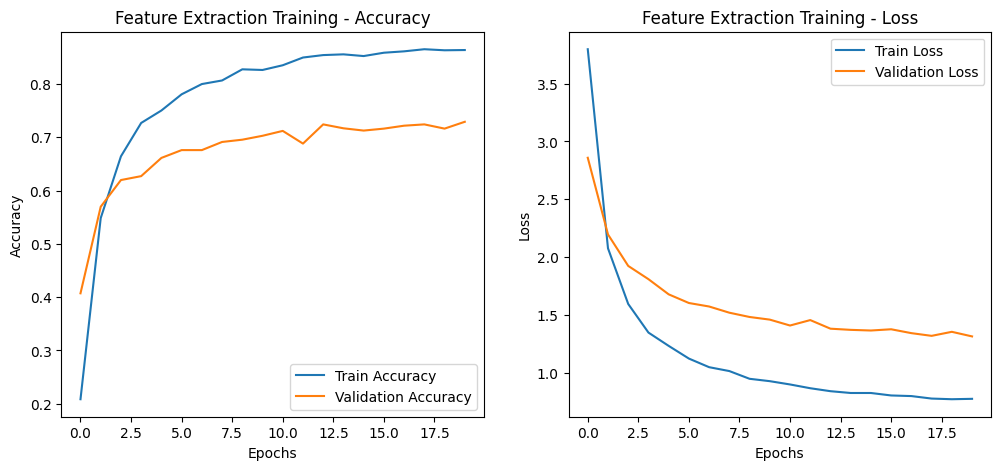

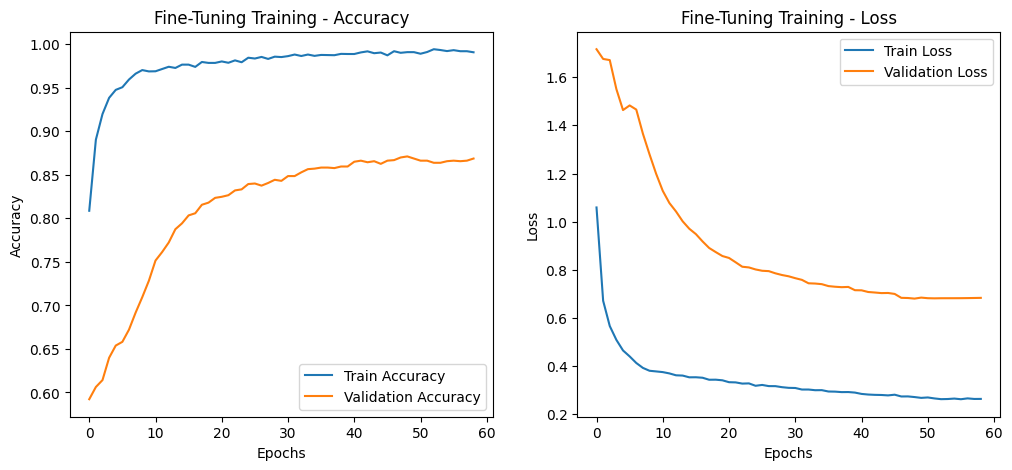

In [43]:
# Plot Training Metrics
def plot_metrics(history, title="Model Performance"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

# Display Metrics
plot_metrics(history, title="Feature Extraction Training")
plot_metrics(history_fine, title="Fine-Tuning Training")


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 130.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 34.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
# prompt: delete all files in given list of folders as well as folders themselves

import shutil
import os

def delete_folders(folders_to_delete):
  """Deletes a list of folders and their contents.

  Args:
    folders_to_delete: A list of folder paths to delete.
  """
  for folder in folders_to_delete:
    if os.path.exists(folder):
      try:
          shutil.rmtree(folder)
          print(f"Successfully deleted folder: {folder}")
      except OSError as e:
          print(f"Error deleting folder {folder}: {e}")
    else:
      print(f"Folder not found: {folder}")


# Example usage (replace with your folder paths)
folders_to_delete = ["model"]
delete_folders(folders_to_delete)


Folder not found: flower_classifier_tfjs
Folder not found: flower_classifier_tfjs_1
Folder not found: flower_classifier_tfjs_2
Folder not found: flower_classifier_tfjs_legacy
Folder not found: flower_classifier_tfjs_legacy_1
Folder not found: converted_model
Successfully deleted folder: model
Folder not found: sample_data


In [ ]:
import tensorflowjs as tfjs

tf.saved_model.save(model, "model/tf/mobileV2/")
# tfjs.converters.save_keras_model(model, "flower_classifier_tfjs")

# model.save("flower_classifier_keras_model.h5")
# tfjs.converters.save_keras_model(model, "model/h5/flower_classifier_tfjs_h5")

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve --weight_shard_size_bytes=30000000 model/tf/mobileV2/ model/tf2js/mobileV2

2025-03-02 23:09:34.664666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740956974.687058   74528 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740956974.693768   74528 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-03-02 23:09:38.991849: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1740956978.991992   74528 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Test Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import scipy.io
import os  # Import os

# Load the SavedModel
loaded_model = tf.saved_model.load("model/tf/mobileV2/")
infer = loaded_model.signatures["serving_default"]

label_data = scipy.io.loadmat("imagelabels.mat")
image_labels = label_data['labels'].flatten() - 1  # 0-based indexing

# Create class_names (assuming sorted filenames match label order)
class_names = [None] * 102
for i in range(len(image_labels)):
    label = image_labels[i]
    if class_names[label] is None:
      class_names[label] = label


# --- Image loading and preprocessing ---
img_path = 'waterlily.jpeg'  # YOUR IMAGE PATH
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make a Prediction
input_name = list(infer.structured_input_signature[1].keys())[0]
predictions = infer(tf.constant(img_array, dtype=tf.float32))
predictions = predictions[list(predictions.keys())[0]]

# --- Get Top-k Predictions and Decode ---
top_k = 10
top_k_indices = np.argsort(predictions[0].numpy())[::-1][:top_k]
top_k_probabilities = tf.gather(predictions[0], top_k_indices).numpy() * 100
top_k_class_names = [text_labels[i] for i in top_k_indices]


# Print the results
print(f"Top {top_k} Predictions:")
for i in range(top_k):
    print(f"  {i+1}. Class: {top_k_class_names[i]}, Probability: {top_k_probabilities[i]:.2f}%")

Top 10 Predictions:
  1. Class: water lily, Probability: 79.09%
  2. Class: great masterwort, Probability: 12.22%
  3. Class: orange dahlia, Probability: 4.13%
  4. Class: tree poppy, Probability: 1.24%
  5. Class: clematis, Probability: 0.46%
  6. Class: gaura, Probability: 0.30%
  7. Class: colt's foot, Probability: 0.22%
  8. Class: lenten rose, Probability: 0.20%
  9. Class: pincushion flower, Probability: 0.18%
  10. Class: bishop of llandaff, Probability: 0.17%
